In [1]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import math
import pandas as pd
from tqdm import tqdm
import numpy as np
import random
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import transforms

In [2]:
user = getpass.getuser()

src = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/"
nifti_paths = list(Path(src).glob('Nifti/**/*.nii'))
mask_r_paths = list(Path(src).glob('**/mask_R.nii.gz'))
mask_l_paths = list(Path(src).glob('**/mask_L.nii.gz'))

In [14]:
def save_nib_file(path, nft, nft_affine):
    nft_2_save = nib.Nifti1Image(nft, nft_affine)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nib.save(nft_2_save, path)


def calibrate_color_values(nft_imgs, low_cv = -1250, high_cv = 250):

    calibrated_values = nft_imgs.copy()
    for i, im in enumerate(calibrated_values):
        if any(any(c > high_cv or c < low_cv for c in r) for r in im):
            calibrated_values[i] = [[max(min(c, high_cv), low_cv) for c in r] for r in im]

    return ((calibrated_values - low_cv) / (high_cv-low_cv)) * 255

def get_z_start_stop(mask):
    start_z = 0

    for z in range(mask.shape[2]):
        if mask[:,:,z].any():
            start_z = z
            break

    stop_z = mask.shape[2]

    for z in reversed(range(mask.shape[2])):
        if mask[:,:,z].any():
            stop_z = z
            break

    return start_z, stop_z


def get_x_start_stop(mask):
    start_x = 0

    for x in range(mask.shape[0]):
        if mask[x,:,:].any():
            start_x = x
            break

    stop_x = mask.shape[0]

    for x in reversed(range(mask.shape[0])):
        if mask[x,:,:].any():
            stop_x = x
            break

    return start_x, stop_x

def get_y_start_stop(mask):
    start_y = 0

    for y in range(mask.shape[1]):
        if mask[:,y,:].any():
            start_y = y
            break

    stop_y = mask.shape[1]

    for y in reversed(range(mask.shape[1])):
        if mask[:,y,:].any():
            stop_y = y
            break

    return start_y, stop_y

def adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y, size=(240, 320)):

    w_diff = size[0] - (stop_x - start_x)

    start_x -= math.ceil(w_diff / 2)
    stop_x += math.floor(w_diff / 2)

    if start_x < 0:
        stop_x -= start_x
        start_x = 0
    elif stop_x > nft_data.shape[0]:
        start_x -= stop_x - nft_data.shape[0]
        stop_x = nft_data.shape[0]

    h_diff = size[1] - (stop_y - start_y)

    start_y -= math.ceil(h_diff / 2)
    stop_y += math.floor(h_diff / 2)

    if start_y < 0:
        stop_y -= start_y
        start_y = 0
    elif stop_y > nft_data.shape[1]:
        start_y -= stop_y - nft_data.shape[1]
        stop_y = nft_data.shape[1]

    return start_x, stop_x, start_y, stop_y

def save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, start_z, stop_z):
        
    df = pd.DataFrame({'name': [file_name],
                       'path': [dst_path],
                       'x': [[start_x, stop_x]],
                       'y': [[start_y, stop_y]],
                       'z': [[start_z, stop_z]]})
    
    dst = str(Path(dst_path).parent) + "/df.csv"

    df.to_csv(dst, mode='a',
                header=not os.path.exists(dst))


def generate_chunks(nft, mask_l, mask_r, dst_path, calibrate_color_value=True, chunk_size=17, spacing=4):

    masks = [mask_l, mask_r]

    nft_data = nft.get_fdata()

    file_name_list = ["L", "R"]

    for i, mask in enumerate(masks):
        
        start_z, stop_z = get_z_start_stop(mask)

        for z in range(start_z + 34, stop_z - 34, chunk_size * spacing): #range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing):

            if chunk_size > 1:
                file_name = f"_{file_name_list[i]}_{z}_{z+chunk_size}.nii"
            else:
                file_name = f"_{file_name_list[i]}_{z}.nii"

            start_x, stop_x = get_x_start_stop(mask[:,:, z : z + chunk_size])
            start_y, stop_y = get_y_start_stop(mask[:,:, z : z + chunk_size])

            if stop_x - start_x > nft_data.shape[0]//2:
                save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, z, z + chunk_size)

            start_x, stop_x, start_y, stop_y = adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y)
            chunk = nft_data[start_x:stop_x, start_y:stop_y, z : z + chunk_size]
            if calibrate_color_value:
                chunk = calibrate_color_values(chunk)

            save_nib_file(dst_path + file_name, chunk, nft.affine)    

In [15]:
def visulize_chunks(nft, mask_l, mask_r, chunk_size=17, spacing=4):

    masks = [mask_l, mask_r]

    nft_data = nft.get_fdata()

    file_name_list = ["L", "R"]

    for i, mask in enumerate(masks):
        
        start_z, stop_z = get_z_start_stop(mask)
        
        start_x, stop_x = get_x_start_stop(mask)
        start_y, stop_y = get_y_start_stop(mask)
        print(mask.shape)
        data = nft_data[start_x:stop_x, 199:200, start_z:stop_z]

        calibrated_data = calibrate_color_values(data)

        fig, ax = plt.subplots()
        plt.imshow(np.rot90(calibrated_data[:,0,:], k=1), cmap='gray')


        highlights = range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing)

        ticks = []

        for z in range(start_z + chunk_size, stop_z - chunk_size, chunk_size):
        
            if z in highlights:
                colors = ['green']
            else:
                colors=['#222222']
            
            ticks.append(stop_z - z)
            plt.hlines(stop_z - z, 0, stop_x - start_x - 1, colors=colors)

        
        #for z in range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing):
        #    ax.add_patch(Rectangle((0,stop_z - z - 17), stop_x - start_x - 1, 17, alpha = 0.5, color = 'green'))
        
        #labels = list(range(17, 17 * (len(ticks) + 1), 17))
        labels = list(range(1, (len(ticks) + 1)))
        #labels.reverse()
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks(ticks, labels=labels)
        ax.yaxis.set_tick_params(width=0)
        plt.ylabel("cm")
        plt.savefig('test_' + file_name_list[i] + '.png', bbox_inches='tight')

        #for z in range(start_z + (chunk_size * spacing) * 2, stop_z - chunk_size*spacing, chunk_size * spacing):

            #file_name = f"/{file_name_list[i]}_{z}_{z+chunk_size}.nii"

            #start_x, stop_x = get_x_start_stop(mask[:,:, z : z + chunk_size])
            #start_y, stop_y = get_y_start_stop(mask[:,:, z : z + chunk_size])

            #if stop_x - start_x > nft_data.shape[0]//2:
            #    save_to_df(file_name, dst_path, start_x, stop_x, start_y, stop_y, z, z + chunk_size)

            #start_x, stop_x, start_y, stop_y = adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y)

            #chunk = calibrate_color_values(nft_data[start_x:stop_x, start_y:stop_y, z : z + chunk_size])

            #save_nib_file(dst_path + file_name, chunk, nft.affine)

(512, 512, 540)
(512, 512, 540)


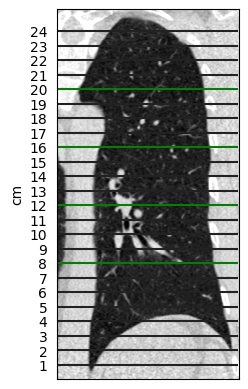

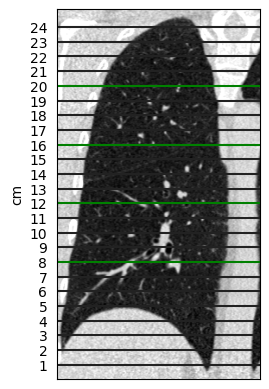

In [69]:
index = 12
nifti_path, mask_r_path, mask_l_path = nifti_paths[index], mask_r_paths[index], mask_l_paths[index]
nft = nib.load(nifti_path)

mask_r = nib.load(mask_r_path).get_fdata()
mask_l = nib.load(mask_l_path).get_fdata()

visulize_chunks(nft, mask_l, mask_r)

In [4]:
def main():

    for nifti_path, mask_r_path, mask_l_path in tqdm(zip(nifti_paths, mask_r_paths, mask_l_paths), total=len(nifti_paths)):

        nft = nib.load(nifti_path)

        mask_r = nib.load(mask_r_path).get_fdata()
        mask_l = nib.load(mask_l_path).get_fdata()

        path = src + 'Preprocessed/' + nifti_path.stem
        
        generate_chunks(nft, mask_l, mask_r, path)

In [4]:
def main_get_full_data():

    for nifti_path, mask_r_path, mask_l_path in tqdm(zip(nifti_paths, mask_r_paths, mask_l_paths), total=len(nifti_paths)):

        nft = nib.load(nifti_path)

        mask_r = nib.load(mask_r_path).get_fdata()
        mask_l = nib.load(mask_l_path).get_fdata()

        path = src + 'FullPreprocessed/' + nifti_path.stem
        
        generate_chunks(nft, mask_l, mask_r, path, calibrate_color_value=True, chunk_size=1, spacing=8)

320


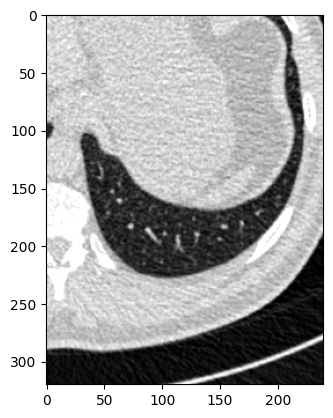

In [55]:
nisan = nib.load('/home/ORUNET/hanta231/2303_Chalmers/Data/BWT_Annotation_Summer2023/1/nifti/1020_bwt_L_93.nii').get_fdata()
plt.imshow(np.rot90(nisan[:,:,0]), cmap='gray')
print(nisan.shape[1])

In [6]:
def generate_subset():

    prep_paths = list(Path(src + 'Preprocessed/').glob('**/*.nii'))  # whereever you want to get files from
    dst_dir = src +  'PreprocessedSubset' # destination folder

    for og_path in tqdm(random.sample(prep_paths, 50)):
        new_name = str(og_path.relative_to(src + 'Preprocessed/')).replace("/", "_")
        output_path = os.path.join(dst_dir, new_name)
        
        nft = nib.load(og_path)
        save_nib_file(output_path, nft.get_fdata(), nft.affine)    

In [4]:
df = pd.read_csv('/home/ORUNET/' + user + '/2303_Chalmers/Mailbox/Till_Hanna_o_Herman/1680240979.csv')
df2 = pd.read_csv('/home/ORUNET/' + user + '/2303_Chalmers/Mailbox/Till_Hanna_o_Herman/1680184624.csv')

In [5]:
list_a = [sc[-22:].replace("/", "_") for sc in list(df["src"])]
list_b = [sc[-22:] for sc in list(df2["src"])]

inconsistencies=[]

overlaps = set(list_a).intersection(set(list_b))

for path in overlaps:
    df_index = list_a.index(path)
    df2_index = list_b.index(path)

    if df.iloc[df_index]["rating"] != df2.iloc[df2_index]["rating"]:
        #print(path,'      ',df.iloc[df_index]["rating"],'      ',df2.iloc[df2_index]["rating"],'      ', df.iloc[df_index]["undone"],'      ',df2.iloc[df2_index]["undone"])
        inconsistencies.append(path)

In [9]:
def generate_subsets_from_csv():

    dst_dir = src + 'NoneSubset' # destination folder
    dst_names = ['NoneSubset', 'MildSubset', 'ModerateSubset']
    inconsistency_counter = 0
    for i in range(3):
        dst_dir = src + dst_names[i]
        for og_path in tqdm(list(df[df['rating'] == i]["src"]) + list(df2[df2['rating'] == i]["src"])):
            if 'MVdrive' in og_path:
                og_path = og_path.replace('../../../../MVdrive/CTCOPD/Data_Analysis/Temp_Access', '/home/ORUNET/' + user)
                new_name = str(Path(og_path).relative_to(src + 'PreprocessedSubset'))
            else: 
                og_path = og_path.replace('../../../Data', '/home/ORUNET/herbe231/2303_Chalmers/Data/BWT')
                new_name = str(Path(og_path).relative_to(src + 'Preprocessed')).replace("/", "_")
            if os.path.isfile(og_path):
                if new_name not in inconsistencies:
                    output_path = os.path.join(dst_dir, new_name)
                    
                    nft = nib.load(og_path)
                    save_nib_file(output_path, nft.get_fdata(), nft.affine)
                else:
                    inconsistency_counter +=1
                    print(inconsistency_counter)

In [10]:
def move_inconsistent_subset():
    dst_dir = src + 'InconsistentSubset' # destination folder
    dst_names = ['NoneSubset', 'MildSubset', 'ModerateSubset']
    nii_paths = []
    for i in range(3):
        nii_paths += list(Path(src+dst_names[i]).glob('*.nii'))
    nii_paths = [nii for nii in nii_paths if str(nii)[-22:] in inconsistencies]

    for og_path in tqdm(nii_paths):
        new_name = str(og_path)[-22:]
        output_path = os.path.join(dst_dir, new_name)
        nft = nib.load(og_path)
        save_nib_file(output_path, nft.get_fdata(), nft.affine)   

In [11]:
def fetch_inconsistent_and_add():

    mild_dst_dir = src + 'InconsistentSubset/MildSubset' # destination folder
    mode_dst_dir = src + 'InconsistentSubset/ModerateSubset' # destination folder

    list_names = [sc[-22:] for sc in list(df2["src"])]

    for name in tqdm(inconsistencies):

        df2_index = list_names.index(name)
        rating = df2.iloc[df2_index]["rating"]

        og_path = df2.iloc[df2_index]["src"].replace('../../../../MVdrive/CTCOPD/Data_Analysis/Temp_Access', '/home/ORUNET/' + user)

        if rating == 2:
            output_path = os.path.join(mode_dst_dir, name)
        else:
            output_path = os.path.join(mild_dst_dir, name)

        nft = nib.load(og_path)
        save_nib_file(output_path, nft.get_fdata(), nft.affine)

In [12]:
non_class_df = pd.read_csv('/home/ORUNET/'+user+'/2303_Chalmers/Mailbox/Till_Hanna_o_Herman/230401_noneklassificering/1680330591.csv')

In [13]:
def fetch_good_none_examples():

    good_dir = src + 'NoneSubset/Good' # destination folder
    bad_dir = src + 'NoneSubset/Bad' # destination folder

    for og_path in tqdm(list(non_class_df["src"])):

        path = og_path.replace('../../../../MVdrive/CTCOPD/Data_Analysis/Temp_Access', '/home/ORUNET/' + user)
        new_name = str(Path(path).relative_to(src + 'NoneSubset'))

        if non_class_df.loc[non_class_df['src'] == og_path]['rating'].values[0] == 0:
            output_path = os.path.join(good_dir, new_name)
        else:
            output_path = os.path.join(bad_dir, new_name)

        nft = nib.load(path)
        save_nib_file(output_path, nft.get_fdata(), nft.affine)

In [14]:
def create_final_subset():
    dst_dir = src + 'TestingSubset'
    '/home/ORUNET/hanta231/2303_Chalmers/Data/BWT/NoneSubset'
    files_none = random.sample(list(Path(src + 'NoneSubset/Good').glob('*.nii')), 25)
    files_mild = random.sample(list(Path(src + 'MildSubset').glob('*.nii')), 30)
    files_mod = random.sample(list(Path(src + 'ModerateSubset').glob('*.nii')), 20)

    for f in tqdm(files_none+files_mild+files_mod):
        output_path = os.path.join(dst_dir, f.name)

        nft = nib.load(f)
        save_nib_file(output_path, nft.get_fdata(), nft.affine)

100%|██████████| 75/75 [01:02<00:00,  1.20it/s]
